In [1]:
place = 'lab'#'colab'#'lab'

In [2]:
# スクリプト内で設定（importの前に）
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
if place == 'colab':
    %pip install -q torch torchvision einops accelerate diffusers transformers webdataset omegaconf h5py tqdm open_clip_torch sentence-transformers deepspeed

## 1. 設定

In [4]:
from huggingface_hub import hf_hub_download

cache_dir = '/mount/nfs6/visitor/nsd/folder/mindeye_v2_cache'
# unCLIPチェックポイント（約6GB）
hf_hub_download(
    'pscotti/mindeyev2', 
    'unclip6_epoch0_step110000.ckpt', 
    repo_type='dataset', 
    local_dir=cache_dir
)

'/mount/nfs6/visitor/nsd/folder/mindeye_v2_cache/unclip6_epoch0_step110000.ckpt'

In [5]:
# =============================================================================
# 推論設定 - 必要に応じて変更してください
# =============================================================================

# 推論モード: "dummy" | "real"
INFERENCE_MODE = "real"

# 被験者ID
SUBJECT = "subj01"

# データパス
DATA_ROOT = "/mount/nfs6/visitor/nsd/algonauts_2023_challenge_data/train_data"#"/content/data/algonauts_2023_challenge_data/train_data/"

# 学習済みモデルのパス
MODEL_CKPT = "/mount/nfs6/visitor/nsd/folder/mindeye_checkpoints/algonauts_subj01_standard/last.pth"

# unCLIP/SDXLモデルのパス（realモード時）
UNCLIP_CKPT = "/mount/nfs6/visitor/nsd/folder/mindeye_v2_cache/unclip6_epoch0_step110000.ckpt" #None

# 出力設定
NUM_SAMPLES = 4  # 生成するサンプル数
OUTPUT_DIR = "/mount/nfs6/visitor/nsd/folder/mindeye_outputs"  # 出力ディレクトリ

# =============================================================================
DUMMY_MODE = (INFERENCE_MODE == "dummy")
print(f"Inference Mode: {INFERENCE_MODE}")
print(f"Subject: {SUBJECT}")
print(f"Model: {MODEL_CKPT}")

Inference Mode: real
Subject: subj01
Model: /mount/nfs6/visitor/nsd/folder/mindeye_checkpoints/algonauts_subj01_standard/last.pth


## 2. 環境構築

In [6]:
# GPU確認
!nvidia-smi

Fri Jan 16 16:40:24 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.06             Driver Version: 570.124.06     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100 80GB PCIe          On  |   00000000:01:00.0 Off |                    0 |
| N/A   31C    P0             40W /  300W |      14MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [7]:
if place == 'colab':
    # 依存パッケージ
    %pip install -q torch torchvision einops omegaconf h5py tqdm

    if not DUMMY_MODE:
        %pip install -q open_clip_torch diffusers transformers kornia

In [8]:
if place == 'colab':
    # リポジトリ準備
    import os
    import sys

    if not os.path.exists("/content/MindEyeV2"):
        !git clone https://github.com/YOUR_USERNAME/MindEyeV2.git /content/MindEyeV2

    sys.path.insert(0, "/content/MindEyeV2/mysrc")
    sys.path.insert(0, "/content/MindEyeV2/src")
    os.chdir("/content/MindEyeV2")

    # 環境変数設定
    os.environ["MINDEYE_DUMMY"] = "1" if DUMMY_MODE else "0"

    print(f"Working directory: {os.getcwd()}")

In [9]:
if place == 'colab':
    # Google Driveマウント
    from google.colab import drive
    drive.mount("/content/drive")

    # 出力ディレクトリ作成
    os.makedirs(OUTPUT_DIR, exist_ok=True)

In [10]:
if place == 'lab':
    # パスを追加
    import sys ,os

    sys.path.insert(0, "/home/pcnl_guest3/workspace/MindEyeV2/mysrc")
    sys.path.insert(0, "/home/pcnl_guest3/workspace/MindEyeV2/src")

    os.chdir("//home/pcnl_guest3/workspace/MindEyeV2")
    print(f"Working directory: {os.getcwd()}")

    # 出力ディレクトリ作成
    os.makedirs(OUTPUT_DIR, exist_ok=True)

Working directory: /home/pcnl_guest3/workspace/MindEyeV2


## 3. モデルロード

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# モジュールインポート
from algonauts_dataset import AlgonautsDataset, get_dataloader, get_total_vertices
from models_algonauts import AlgonautsMindEye
from transfer_utils import load_checkpoint, get_state_dict_from_checkpoint
from config import DEVICE

print(f"Device: {DEVICE}")

Device: cuda


In [12]:
# チェックポイントからモデル設定を復元
checkpoint = load_checkpoint(MODEL_CKPT)

# モデル設定（ckptに保存されていれば使用、なければデフォルト）
hidden_dim = checkpoint.get("hidden_dim", 256)
subject = checkpoint.get("subject", SUBJECT)

print(f"Checkpoint info:")
print(f"  Epoch: {checkpoint.get('epoch', 'N/A')}")
print(f"  Hidden dim: {hidden_dim}")
print(f"  Subject: {subject}")
print(f"  Final loss: {checkpoint.get('final_loss', 'N/A')}")

Loading checkpoint from: /mount/nfs6/visitor/nsd/folder/mindeye_checkpoints/algonauts_subj01_standard/last.pth
Checkpoint info:
  Epoch: 20
  Hidden dim: 1024
  Subject: subj01
  Final loss: 0.00028708777972497046


In [13]:
# モデル作成
model = AlgonautsMindEye(
    subjects=[subject],
    hidden_dim=hidden_dim,
    seq_len=1,
    n_blocks=4,
    use_prior=False,
    blurry_recon=False,
)

# 重みロード
state_dict = get_state_dict_from_checkpoint(checkpoint)
model.load_state_dict(state_dict, strict=False)
model = model.to(DEVICE).eval()

print("Model loaded!")
print(f"Total vertices: {get_total_vertices(subject)}")

/home/pcnl_guest3/miniforge3/envs/fmri3/lib/python3.11/site-packages/clip/clip.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import packaging
/home/pcnl_guest3/miniforge3/envs/fmri3/lib/python3.11/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
/home/pcnl_guest3/miniforge3/envs/fmri3/lib/python3.11/site-packages/timm/models/layers/__init__.py:49: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Model loaded!
Total vertices: 39548


## 4. 画像生成器の準備

In [14]:
if DUMMY_MODE:
    from dummy_models import DummyDiffusionEngine
    
    diffusion_engine = DummyDiffusionEngine(output_size=512).to(DEVICE)
    print("Using DummyDiffusionEngine (outputs will be random)")
    
    def generate_image(clip_tokens):
        """ダミー画像生成"""
        with torch.no_grad():
            # ダミー潜在変数
            z = torch.randn(clip_tokens.shape[0], 4, 64, 64, device=DEVICE)
            images = diffusion_engine.decode_first_stage(z)
        return images

else:
    from omegaconf import OmegaConf    
    sys.path.append(os.path.abspath('/home/pcnl_guest3/workspace/MindEyeV2/src/generative_models'))
    from generative_models.sgm.models.diffusion import DiffusionEngine
    device = DEVICE
    # 本物のunCLIPを使用
    print("Loading real diffusion model...")
    
    # SGM/unCLIPのロード（要実装）
    # この部分は元のrecon_inference.ipynbを参照して実装
    # raise NotImplementedError(
    #     "Real inference mode requires additional setup. "
    #     "Please implement unCLIP loading based on src/recon_inference.ipynb"
    # )
    # unCLIP（拡散復元エンジン）の準備
    config = OmegaConf.load("/home/pcnl_guest3/workspace/MindEyeV2/src/generative_models/configs/unclip6.yaml")
    config = OmegaConf.to_container(config, resolve=True)
    unclip_params = config["model"]["params"]
    network_config = unclip_params["network_config"]
    denoiser_config = unclip_params["denoiser_config"]
    first_stage_config = unclip_params["first_stage_config"]
    conditioner_config = unclip_params["conditioner_config"]
    sampler_config = unclip_params["sampler_config"]
    scale_factor = unclip_params["scale_factor"]
    disable_first_stage_autocast = unclip_params["disable_first_stage_autocast"]
    offset_noise_level = unclip_params["loss_fn_config"]["params"]["offset_noise_level"]

    # AutoencoderのターゲットをSGM実装に合わせ、サンプリングステップ数を調整
    first_stage_config['target'] = 'sgm.models.autoencoder.AutoencoderKL'
    sampler_config['params']['num_steps'] = 38

    diffusion_engine = DiffusionEngine(network_config=network_config,
                        denoiser_config=denoiser_config,
                        first_stage_config=first_stage_config,
                        conditioner_config=conditioner_config,
                        sampler_config=sampler_config,
                        scale_factor=scale_factor,
                        disable_first_stage_autocast=disable_first_stage_autocast)
    # 推論モードに設定しデバイスへ配置
    diffusion_engine.eval().requires_grad_(False)
    diffusion_engine.to(device)

    # 学習済みunCLIPのチェックポイントを読み込み
    ckpt_path = '/mount/nfs6/visitor/nsd/folder/mindeye_v2_cache/unclip6_epoch0_step110000.ckpt'
    ckpt = torch.load(ckpt_path, map_location='cpu')
    diffusion_engine.load_state_dict(ckpt['state_dict'])

    # conditionerからunCLIP用の付加ベクトル（suffix）を取得
    batch={"jpg": torch.randn(1,3,1,1).to(device), # jpgは未使用のダミー
        "original_size_as_tuple": torch.ones(1, 2).to(device) * 768,
        "crop_coords_top_left": torch.zeros(1, 2).to(device)}
    out = diffusion_engine.conditioner(batch)
    vector_suffix = out["vector"].to(device)
    print("vector_suffix", vector_suffix.shape)

SpatialTransformer: Found context dims [1664] of depth 1, which does not match the specified 'depth' of 2. Setting context_dim to [1664, 1664] now.


Loading real diffusion model...


SpatialTransformer: Found context dims [1664] of depth 1, which does not match the specified 'depth' of 2. Setting context_dim to [1664, 1664] now.
SpatialTransformer: Found context dims [1664] of depth 1, which does not match the specified 'depth' of 10. Setting context_dim to [1664, 1664, 1664, 1664, 1664, 1664, 1664, 1664, 1664, 1664] now.
SpatialTransformer: Found context dims [1664] of depth 1, which does not match the specified 'depth' of 10. Setting context_dim to [1664, 1664, 1664, 1664, 1664, 1664, 1664, 1664, 1664, 1664] now.
SpatialTransformer: Found context dims [1664] of depth 1, which does not match the specified 'depth' of 10. Setting context_dim to [1664, 1664, 1664, 1664, 1664, 1664, 1664, 1664, 1664, 1664] now.
SpatialTransformer: Found context dims [1664] of depth 1, which does not match the specified 'depth' of 10. Setting context_dim to [1664, 1664, 1664, 1664, 1664, 1664, 1664, 1664, 1664, 1664] now.
SpatialTransformer: Found context dims [1664] of depth 1, which 

Initialized embedder #0: FrozenOpenCLIPImageEmbedder with 1909889025 params. Trainable: False
Initialized embedder #1: ConcatTimestepEmbedderND with 0 params. Trainable: False
Initialized embedder #2: ConcatTimestepEmbedderND with 0 params. Trainable: False


/home/pcnl_guest3/workspace/MindEyeV2/src/generative_models/sgm/util.py:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(


vector_suffix torch.Size([1, 1024])


In [15]:
# state_dictが無い場合は再ロード
if 'state_dict' not in dir() or state_dict is None:
    checkpoint = load_checkpoint(MODEL_CKPT)
    state_dict = get_state_dict_from_checkpoint(checkpoint)

In [16]:
# generate_image 関数の定義（セル13の後、セル14の前に追加）

import sys
sys.path.append('/home/pcnl_guest3/workspace/MindEyeV2/src')
import utils
from models import PriorNetwork, BrainDiffusionPrior

clip_seq_dim = 256
clip_emb_dim = 1664

# Diffusion Prior の構築
prior_network = PriorNetwork(
    dim=clip_emb_dim,
    depth=6,
    dim_head=52,
    heads=clip_emb_dim // 52,
    causal=False,
    num_tokens=clip_seq_dim,
    learned_query_mode="pos_emb"
)

diffusion_prior = BrainDiffusionPrior(
    net=prior_network,
    image_embed_dim=clip_emb_dim,
    condition_on_text_encodings=False,
    timesteps=100,
    cond_drop_prob=0.2,
    image_embed_scale=None,
).to(DEVICE)
diffusion_prior.eval().requires_grad_(False)

# チェックポイントからdiffusion_priorの重みをロード
prior_state = {k.replace('diffusion_prior.', ''): v 
               for k, v in state_dict.items() if 'diffusion_prior' in k}
if prior_state:
    diffusion_prior.load_state_dict(prior_state, strict=False)
    print(f"Loaded diffusion_prior weights: {len(prior_state)} keys")
else:
    print("Warning: No diffusion_prior weights found in checkpoint")

def generate_image(clip_voxels):
    """
    clip_voxels (backbone出力) から画像を生成
    
    Args:
        clip_voxels: backbone出力 shape (batch, seq*dim) または (batch, seq, dim)
        
    Returns:
        images: 生成画像 shape (batch, 3, H, W)
    """
    with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.float16):
        # clip_voxels の形状を確認・調整
        # AlgonautsMindEye の backbone 出力は (batch, clip_seq_dim * clip_emb_dim)
        if clip_voxels.dim() == 2:
            batch_size = clip_voxels.shape[0]
            # (batch, seq*dim) -> (batch, seq, dim)
            backbone = clip_voxels.view(batch_size, clip_seq_dim, clip_emb_dim)
        else:
            backbone = clip_voxels
        
        # Diffusion Prior でサンプリング
        prior_out = diffusion_prior.p_sample_loop(
            backbone.shape,
            text_cond=dict(text_embed=backbone),
            cond_scale=1.,
            timesteps=20
        )
        
        # unCLIP で画像生成
        images = utils.unclip_recon(
            prior_out,
            diffusion_engine,
            vector_suffix,
            num_samples=1
        )
    
    return images

print("generate_image function ready!")

Loaded diffusion_prior weights: 86 keys
generate_image function ready!


In [17]:
# generate_image 関数の定義（セル13の後に追加）

# Diffusion Prior のロード（AlgonautsMindEyeにない場合）
from models import PriorNetwork, BrainDiffusionPrior

clip_seq_dim = 256
clip_emb_dim = 1664

# Prior Network の構築
prior_network = PriorNetwork(
    dim=clip_emb_dim,
    depth=6,
    dim_head=52,
    heads=clip_emb_dim // 52,
    causal=False,
    num_tokens=clip_seq_dim,
    learned_query_mode="pos_emb"
)

diffusion_prior = BrainDiffusionPrior(
    net=prior_network,
    image_embed_dim=clip_emb_dim,
    condition_on_text_encodings=False,
    timesteps=100,
    cond_drop_prob=0.2,
    image_embed_scale=None,
).to(DEVICE)
diffusion_prior.eval().requires_grad_(False)

# チェックポイントからdiffusion_priorの重みをロード（存在すれば）
if 'diffusion_prior' in str(state_dict.keys()):
    prior_state = {k.replace('diffusion_prior.', ''): v 
                   for k, v in state_dict.items() if 'diffusion_prior' in k}
    diffusion_prior.load_state_dict(prior_state, strict=False)
    print("Loaded diffusion_prior weights from checkpoint")

# utils をインポート
import sys
sys.path.append('/home/pcnl_guest3/workspace/MindEyeV2/src')
import utils

def generate_image(clip_tokens):
    """
    CLIP tokens (backbone出力) から画像を生成
    
    Args:
        clip_tokens: backbone出力 shape (batch, seq, dim) または (batch, dim*seq)
        
    Returns:
        images: 生成画像 shape (batch, 3, H, W)
    """
    with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.float16):
        # clip_tokens の形状を確認・調整
        if clip_tokens.dim() == 2:
            # (batch, dim*seq) -> (batch, seq, dim)
            batch_size = clip_tokens.shape[0]
            clip_tokens = clip_tokens.view(batch_size, clip_seq_dim, clip_emb_dim)
        
        # Diffusion Prior でサンプリング
        prior_out = diffusion_prior.p_sample_loop(
            clip_tokens.shape,
            text_cond=dict(text_embed=clip_tokens),
            cond_scale=1.,
            timesteps=20
        )
        
        # unCLIP で画像生成
        images = utils.unclip_recon(
            prior_out,
            diffusion_engine,
            vector_suffix,
            num_samples=1
        )
    
    return images

print("generate_image function ready!")

Loaded diffusion_prior weights from checkpoint
generate_image function ready!


## 5. データ準備

In [18]:
# データセット
dataset = AlgonautsDataset(
    data_root=DATA_ROOT,
    subject=subject,
    split="train",
    load_images=True,
)

print(f"Dataset size: {len(dataset)}")

Loading fMRI data for subj01...
  LH shape: (9841, 19004), RH shape: (9841, 20544)
  Combined shape: (9841, 39548)
Found 9841 train images
Dataset size: 9841


In [19]:
# サンプルインデックスをランダムに選択
np.random.seed(42)
sample_indices = np.random.choice(len(dataset), NUM_SAMPLES, replace=False)
print(f"Sample indices: {sample_indices}")

Sample indices: [7763 8655  106  439]


## 6. 推論実行

In [20]:
def denormalize(tensor):
    """ImageNet正規化を元に戻す"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(tensor.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(tensor.device)
    return tensor * std + mean

def to_pil(tensor):
    """Tensor to PIL Image"""
    if tensor.dim() == 4:
        tensor = tensor[0]
    img = tensor.cpu().permute(1, 2, 0).numpy()
    img = np.clip(img * 255, 0, 255).astype(np.uint8)
    return Image.fromarray(img)

In [21]:
# 推論実行
results = []

model.eval()
with torch.no_grad():
    for idx in sample_indices:
        sample = dataset[idx]
        
        # fMRI入力
        fmri = sample['fmri'].unsqueeze(0).to(DEVICE)
        
        # 元画像
        original_image = sample['image'].unsqueeze(0)
        
        # fMRI → CLIP tokens
        backbone, clip_voxels, _ = model(fmri)
        
        # CLIP tokens → 画像
        recon_images = generate_image(clip_voxels)
        
        results.append({
            'index': idx,
            'original': denormalize(original_image),
            'reconstruction': recon_images,
            'clip_tokens': clip_voxels,
        })
        
        print(f"Processed sample {idx}")

print(f"\nGenerated {len(results)} reconstructions")

/tmp/ipykernel_3187422/2228283509.py:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.float16):


sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

/home/pcnl_guest3/workspace/MindEyeV2/src/utils.py:259: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.float16), diffusion_engine.ema_scope():
/home/pcnl_guest3/miniforge3/envs/fmri3/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/pcnl_guest3/miniforge3/envs/fmri3/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Processed sample 7763


sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

Processed sample 8655


sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

Processed sample 106


sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

Processed sample 439

Generated 4 reconstructions


## 7. 結果の可視化

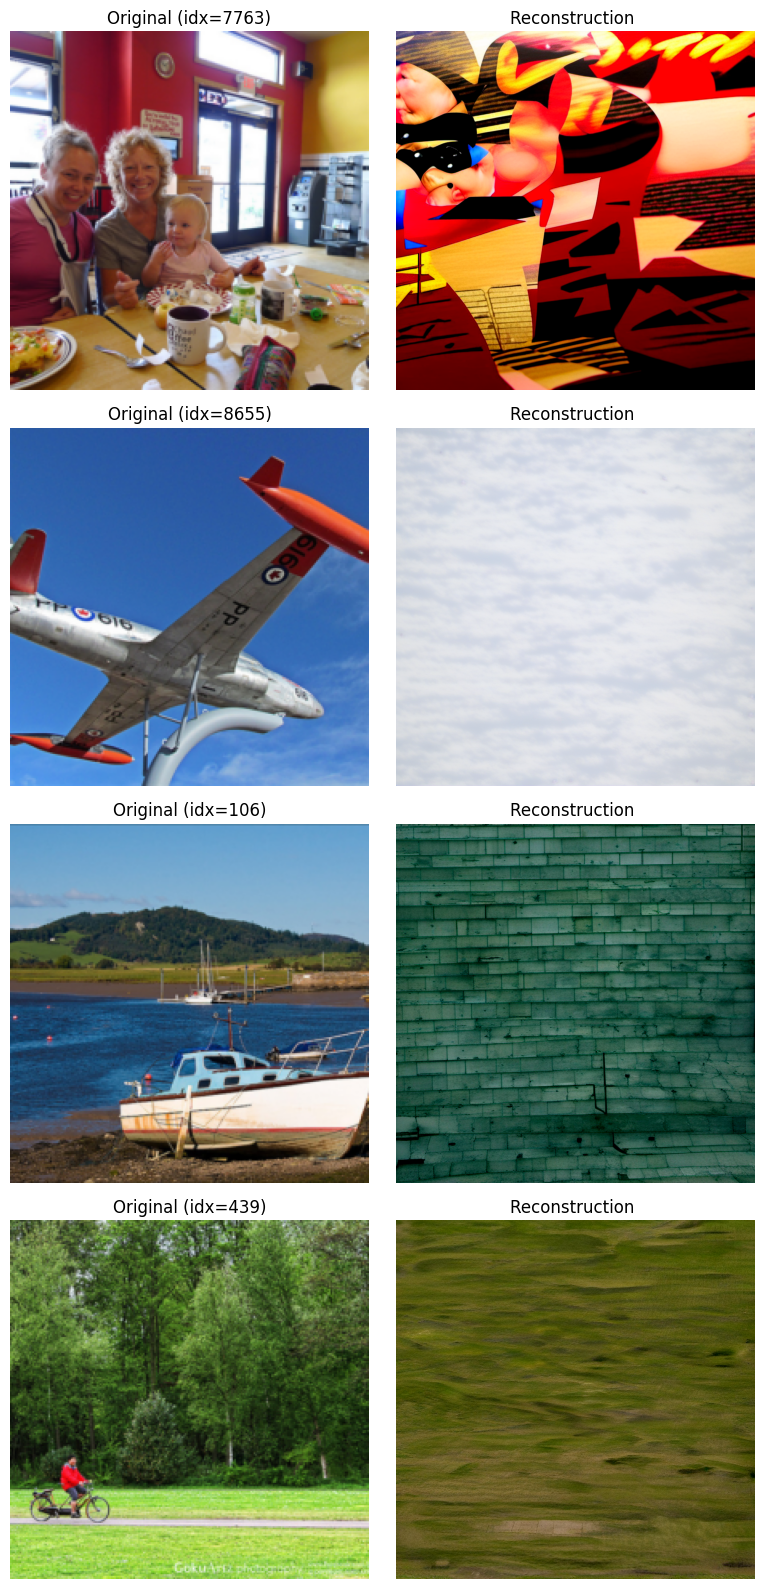


Saved to: /mount/nfs6/visitor/nsd/folder/mindeye_outputs/reconstruction_comparison.png


In [22]:
# 結果を並べて表示
fig, axes = plt.subplots(NUM_SAMPLES, 2, figsize=(8, 4 * NUM_SAMPLES))

for i, result in enumerate(results):
    # 元画像
    ax_orig = axes[i, 0] if NUM_SAMPLES > 1 else axes[0]
    orig_img = result['original'][0].cpu().permute(1, 2, 0).numpy()
    orig_img = np.clip(orig_img, 0, 1)
    ax_orig.imshow(orig_img)
    ax_orig.set_title(f"Original (idx={result['index']})")
    ax_orig.axis('off')
    
    # 再構成画像
    ax_recon = axes[i, 1] if NUM_SAMPLES > 1 else axes[1]
    recon_img = result['reconstruction'][0].cpu().permute(1, 2, 0).numpy()
    recon_img = np.clip(recon_img, 0, 1)
    ax_recon.imshow(recon_img)
    ax_recon.set_title(f"Reconstruction {'(DUMMY)' if DUMMY_MODE else ''}")
    ax_recon.axis('off')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "reconstruction_comparison.png"), dpi=150)
plt.show()

print(f"\nSaved to: {os.path.join(OUTPUT_DIR, 'reconstruction_comparison.png')}")

In [23]:
# 個別画像を保存
for i, result in enumerate(results):
    # 元画像
    orig_pil = to_pil(result['original'])
    orig_pil.save(os.path.join(OUTPUT_DIR, f"original_{result['index']:04d}.png"))
    
    # 再構成画像
    recon_pil = to_pil(result['reconstruction'])
    recon_pil.save(os.path.join(OUTPUT_DIR, f"recon_{result['index']:04d}.png"))

print(f"Saved {len(results)} image pairs to {OUTPUT_DIR}")

Saved 4 image pairs to /mount/nfs6/visitor/nsd/folder/mindeye_outputs


## 8. CLIP特徴の分析

In [24]:
# CLIP特徴の統計
all_clips = torch.cat([r['clip_tokens'] for r in results], dim=0)

print(f"CLIP tokens shape: {all_clips.shape}")
print(f"Mean: {all_clips.mean().item():.4f}")
print(f"Std: {all_clips.std().item():.4f}")
print(f"Min: {all_clips.min().item():.4f}")
print(f"Max: {all_clips.max().item():.4f}")

CLIP tokens shape: torch.Size([4, 256, 1664])
Mean: -0.0022
Std: 0.5258
Min: -19.0523
Max: 17.7720


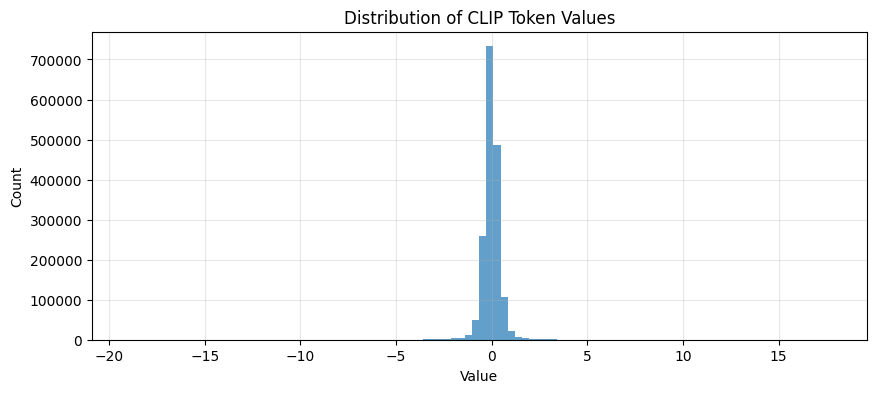

In [25]:
# CLIP特徴のヒストグラム
plt.figure(figsize=(10, 4))
plt.hist(all_clips.cpu().numpy().flatten(), bins=100, alpha=0.7)
plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Distribution of CLIP Token Values")
plt.grid(True, alpha=0.3)
plt.show()

## 次のステップ

1. **ダミーモードで動作確認** → エラーなく画像が出力されればOK
2. **realモードで本格推論** → unCLIPモデルをロードして実行
3. **定量評価** → 元画像との類似度を計算
4. **transformer_brain_encoder統合** → 画像→fMRI→画像の往復テスト

In [26]:
!git clone https://github.com/MedARC-AI/MindEyeV2.git
%cd MindEyeV2/src

fatal: destination path 'MindEyeV2' already exists and is not an empty directory.
/home/pcnl_guest3/workspace/MindEyeV2/MindEyeV2/src


In [27]:
from huggingface_hub import hf_hub_download
cache_dir = './'
# 軽量モデル (hidden_dim=1024, low-level module なし)
hf_hub_download('pscotti/mindeyev2', 'train_logs/multisubject_subj01_1024hid_nolow_300ep/last.pth', repo_type='dataset', local_dir=cache_dir)
hf_hub_download('pscotti/mindeyev2', 'unclip6_epoch0_step110000.ckpt', repo_type='dataset', local_dir=cache_dir)
hf_hub_download('pscotti/mindeyev2', 'bigG_to_L_epoch8.pth', repo_type='dataset', local_dir=cache_dir)
print('downloaded model files')

downloaded model files


## fMRI ベクトルのアップロード
前処理ノートで作成した `voxel.npy` をアップロードしてください。

In [28]:
from google.colab import files
import numpy as np, torch
uploaded = files.upload()
voxel = torch.tensor(np.load(list(uploaded.keys())[0])).float()[None,None]
print('voxel shape:', voxel.shape)

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
import torch.nn as nn
from torchvision import transforms
from accelerate import Accelerator
import utils
from models import BrainNetwork, PriorNetwork, BrainDiffusionPrior

accelerator = Accelerator(split_batches=False, mixed_precision='fp16')
device = accelerator.device
hidden_dim = 1024  # 軽量モデル用
clip_seq_dim, clip_emb_dim = 256, 1664

# 事前に ckpt を読み込んでボクセル次元を取得
ckpt = torch.load('./train_logs/multisubject_subj01_1024hid_nolow_300ep/last.pth', map_location='cpu', weights_only=False)
expected_voxels = ckpt['model_state_dict']['ridge.linears.0.weight'].shape[1]
print('expected voxels from ckpt:', expected_voxels)

class MindEyeModule(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, x): return x

class RidgeRegression(nn.Module):
    def __init__(self, input_sizes, out_features):
        super().__init__()
        self.linears = nn.ModuleList([nn.Linear(s, out_features) for s in input_sizes])
    def forward(self, x, subj_idx):
        return self.linears[subj_idx](x[:,0]).unsqueeze(1)

model = MindEyeModule()
model.ridge = RidgeRegression([expected_voxels], out_features=hidden_dim)
model.backbone = BrainNetwork(h=hidden_dim, in_dim=hidden_dim, seq_len=1, clip_size=clip_emb_dim, out_dim=clip_emb_dim*clip_seq_dim, blurry_recon=False)  # low-level なし
prior_network = PriorNetwork(dim=clip_emb_dim, depth=6, dim_head=52, heads=clip_emb_dim//52, causal=False, num_tokens=clip_seq_dim, learned_query_mode='pos_emb')
model.diffusion_prior = BrainDiffusionPrior(net=prior_network, image_embed_dim=clip_emb_dim, condition_on_text_encodings=False, timesteps=100, cond_drop_prob=0.2, image_embed_scale=None)
model.load_state_dict(ckpt['model_state_dict'], strict=False)
model.to(device).eval().requires_grad_(False)
print('model ready')

In [ ]:
import sys, os
sys.path.append(os.path.abspath('/home/pcnl_guest3/workspace/MindEyeV2/src/generative_models'))
from omegaconf import OmegaConf
from generative_models.sgm.models.diffusion import DiffusionEngine
config = OmegaConf.load('/home/pcnl_guest3/workspace/MindEyeV2/src/generative_models/configs/unclip6.yaml')
params = OmegaConf.to_container(config, resolve=True)['model']['params']
params['first_stage_config']['target'] = 'sgm.models.autoencoder.AutoencoderKL'
params['sampler_config']['params']['num_steps'] = 38
diffusion_engine = DiffusionEngine(network_config=params['network_config'], denoiser_config=params['denoiser_config'], first_stage_config=params['first_stage_config'], conditioner_config=params['conditioner_config'], sampler_config=params['sampler_config'], scale_factor=params['scale_factor'], disable_first_stage_autocast=params['disable_first_stage_autocast']).to(device)
diffusion_engine.load_state_dict(torch.load('unclip6_epoch0_step110000.ckpt', map_location='cpu')['state_dict'])
diffusion_engine.eval().requires_grad_(False)
batch = {'jpg': torch.randn(1,3,1,1).to(device), 'original_size_as_tuple': torch.ones(1,2).to(device)*768, 'crop_coords_top_left': torch.zeros(1,2).to(device)}
vector_suffix = diffusion_engine.conditioner(batch)['vector'].to(device)
print('unclip ready', vector_suffix.shape)

SpatialTransformer: Found context dims [1664] of depth 1, which does not match the specified 'depth' of 2. Setting context_dim to [1664, 1664] now.
SpatialTransformer: Found context dims [1664] of depth 1, which does not match the specified 'depth' of 2. Setting context_dim to [1664, 1664] now.
SpatialTransformer: Found context dims [1664] of depth 1, which does not match the specified 'depth' of 10. Setting context_dim to [1664, 1664, 1664, 1664, 1664, 1664, 1664, 1664, 1664, 1664] now.
SpatialTransformer: Found context dims [1664] of depth 1, which does not match the specified 'depth' of 10. Setting context_dim to [1664, 1664, 1664, 1664, 1664, 1664, 1664, 1664, 1664, 1664] now.
SpatialTransformer: Found context dims [1664] of depth 1, which does not match the specified 'depth' of 10. Setting context_dim to [1664, 1664, 1664, 1664, 1664, 1664, 1664, 1664, 1664, 1664] now.
SpatialTransformer: Found context dims [1664] of depth 1, which does not match the specified 'depth' of 10. Setti

open_clip_pytorch_model.bin:   0%|          | 0.00/10.2G [00:00<?, ?B/s]

Initialized embedder #0: FrozenOpenCLIPImageEmbedder with 1909889025 params. Trainable: False
Initialized embedder #1: ConcatTimestepEmbedderND with 0 params. Trainable: False
Initialized embedder #2: ConcatTimestepEmbedderND with 0 params. Trainable: False


FileNotFoundError: [Errno 2] No such file or directory: 'unclip6_epoch0_step110000.ckpt'

In [ ]:
from transformers import AutoProcessor
from modeling_git import GitForCausalLMClipEmb
processor = AutoProcessor.from_pretrained('microsoft/git-large-coco')
clip_text_model = GitForCausalLMClipEmb.from_pretrained('microsoft/git-large-coco').to(device)
clip_text_model.eval().requires_grad_(False)
class CLIPConverter(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(clip_seq_dim, 257)
        self.linear2 = nn.Linear(clip_emb_dim, 1024)
    def forward(self, x):
        x = self.linear1(x.permute(0,2,1))
        return self.linear2(x.permute(0,2,1))
clip_convert = CLIPConverter().to(device)
clip_convert.load_state_dict(torch.load('bigG_to_L_epoch8.pth', map_location='cpu')['model_state_dict'])
print('caption model ready')

In [ ]:
import matplotlib.pyplot as plt
from torchvision import transforms

# voxel 次元を ckpt に合わせる（不足はゼロ埋め、超過は切り詰め）
if voxel.shape[-1] < expected_voxels:
    pad = expected_voxels - voxel.shape[-1]
    voxel = torch.cat([voxel, torch.zeros(*voxel.shape[:-1], pad)], dim=-1)
elif voxel.shape[-1] > expected_voxels:
    voxel = voxel[..., :expected_voxels]

model.eval(); clip_text_model.eval(); diffusion_engine.eval()
with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.float16):
    voxel_d = voxel.to(device)
    voxel_ridge = model.ridge(voxel_d, 0)
    backbone, clip_voxels, _ = model.backbone(voxel_ridge)
    prior_out = model.diffusion_prior.p_sample_loop(backbone.shape, text_cond={'text_embed': backbone}, cond_scale=1., timesteps=20)
    pred_caption_emb = clip_convert(prior_out)
    generated_ids = clip_text_model.generate(pixel_values=pred_caption_emb, max_length=20)
    caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    samples = utils.unclip_recon(prior_out, diffusion_engine, vector_suffix, num_samples=1)[0].cpu()
print('caption:', caption)
plt.imshow(transforms.ToPILImage()(samples)); plt.axis('off'); plt.show()